In [1]:
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [2]:
base_url = 'https://www.football-data.co.uk/mmz4281/'

seasons = ['1314', '1415', '1516', '1617', '1718', '1819', '1920', '2021', '2122', '2223']

columns = [
    'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR',
    'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR'
]

urls = [base_url + season + '/E0.csv' for season in seasons]
data = [pd.read_csv(url, usecols = columns) for url in urls]

df = pd.concat(data, ignore_index = True)

In [3]:
# df.info()
# df.describe()

df.isna().values.sum()
df.dropna(inplace = True)

df.head()

,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,Arsenal,Aston Villa,1.0,3.0,A,1.0,1.0,D,16.0,9.0,4.0,4.0,15.0,18.0,4.0,3.0,4.0,5.0,1.0,0.0
1,Liverpool,Stoke,1.0,0.0,H,1.0,0.0,H,26.0,10.0,11.0,4.0,11.0,11.0,12.0,6.0,1.0,1.0,0.0,0.0
2,Norwich,Everton,2.0,2.0,D,0.0,0.0,D,8.0,19.0,2.0,6.0,13.0,10.0,6.0,8.0,2.0,0.0,0.0,0.0
3,Sunderland,Fulham,0.0,1.0,A,0.0,0.0,D,20.0,5.0,3.0,1.0,14.0,14.0,6.0,1.0,0.0,3.0,0.0,0.0
4,Swansea,Man United,1.0,4.0,A,0.0,2.0,A,17.0,15.0,6.0,7.0,13.0,10.0,7.0,4.0,1.0,3.0,0.0,0.0


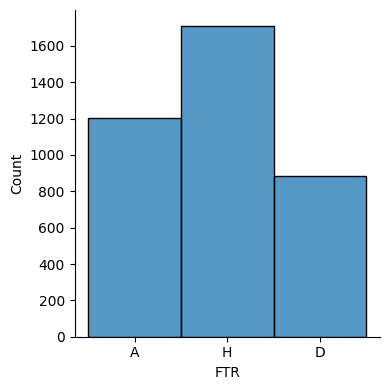

In [4]:
sns.displot(df['FTR'], height = 4);

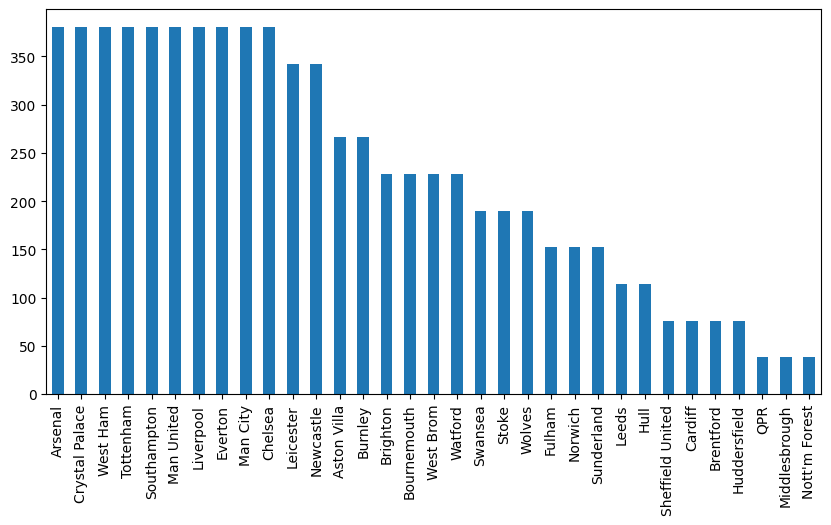

In [5]:
matches = df['HomeTeam'].value_counts() + df['AwayTeam'].value_counts()
matches = matches.sort_values(ascending = False)

matches.plot(kind = 'bar', figsize = (10, 5));

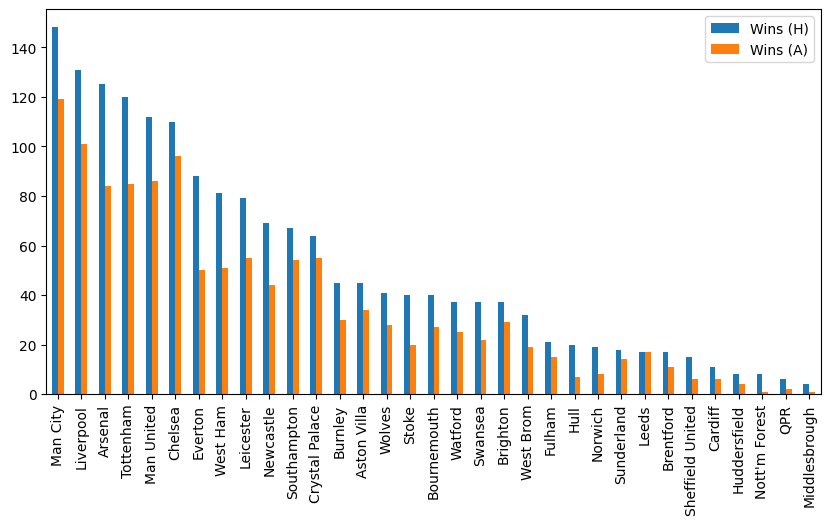

In [6]:
outcomes = pd.DataFrame()

outcomes['Wins (H)'] = df[df['FTR'] == 'H']['HomeTeam'].value_counts()
outcomes['Wins (A)'] = df[df['FTR'] == 'A']['AwayTeam'].value_counts()

outcomes.plot(kind = 'bar', figsize = (10, 5));

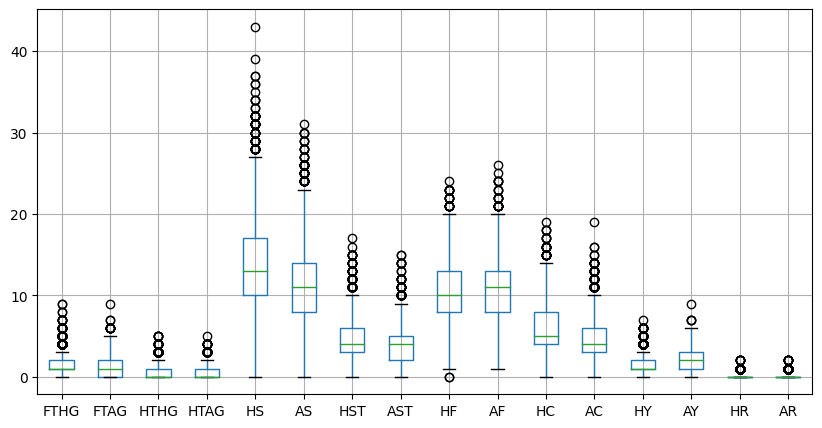

In [7]:
df.boxplot(figsize = (10, 5));

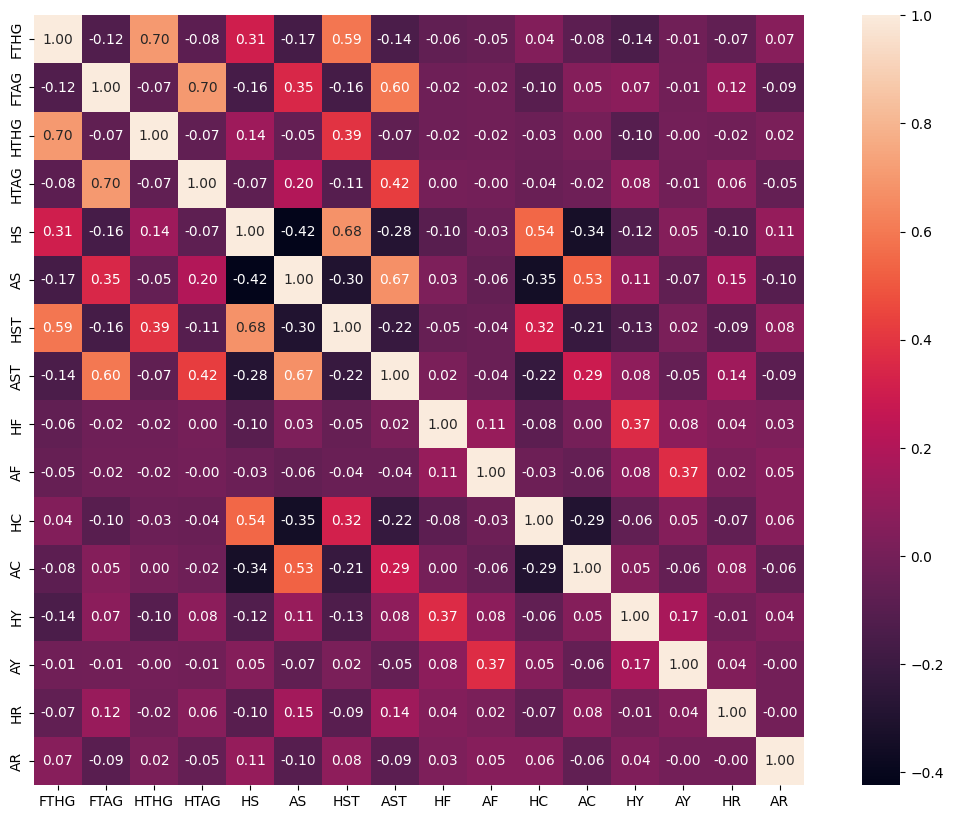

In [8]:
plt.figure(figsize = (15, 10))

correlation = df.corr(numeric_only = True)
sns.heatmap(correlation, annot = True, square = True, fmt = '.2f');

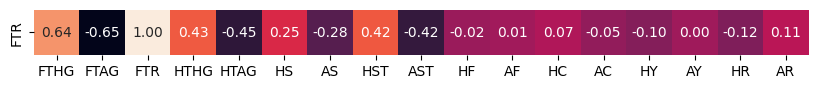

In [9]:
plt.figure(figsize = (10, 2))

df_corr = df.copy()
df_corr['FTR'].replace({'H': 1, 'D': 0, 'A': -1}, inplace = True)

correlation = df_corr.corr(numeric_only = True)[['FTR']].T
sns.heatmap(correlation, annot = True, square = True, cbar = False, fmt = '.2f');

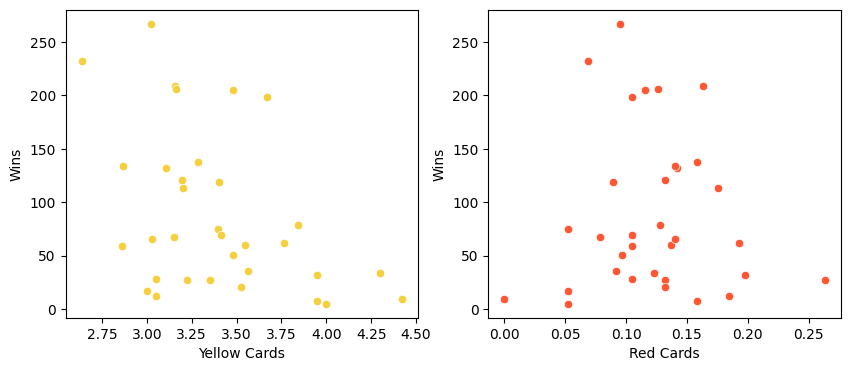

In [10]:
scatter = pd.DataFrame()

scatter['Wins'] = outcomes['Wins (H)'] + outcomes['Wins (A)']

HY = df.groupby('HomeTeam')['HY'].mean()
AY = df.groupby('AwayTeam')['AY'].mean()

scatter['Yellow Cards'] = HY + AY

HR = df.groupby('HomeTeam')['HR'].mean()
AR = df.groupby('AwayTeam')['AR'].mean()

scatter['Red Cards'] = HR + AR

figure, axes = plt.subplots(1, 2, figsize = (10, 4))

sns.scatterplot(x = 'Yellow Cards', y = 'Wins', data = scatter, c = '#F4D03F', ax = axes[0])
sns.scatterplot(x = 'Red Cards', y = 'Wins', data = scatter, c = '#FF5733', ax = axes[1])

plt.show()

In [11]:
df = df.drop(['HTHG', 'HTAG', 'HS', 'AS', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR'], axis = 1)

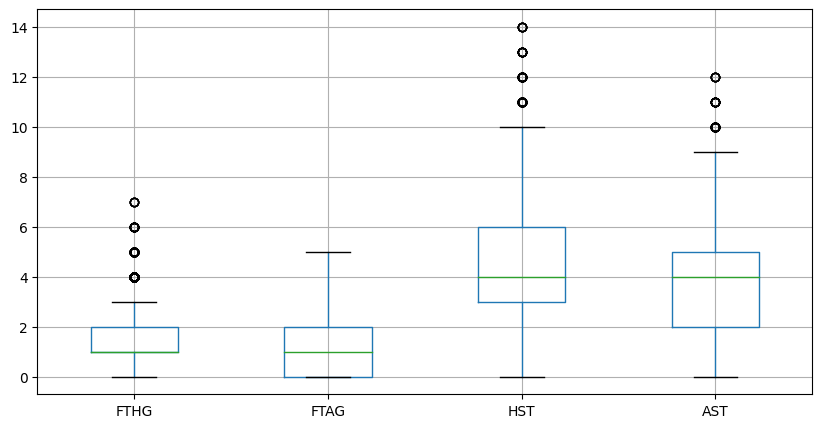

In [12]:
Q1 = df.quantile(0.15, numeric_only = True)
Q3 = df.quantile(0.85, numeric_only = True)

IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

df, lower = df.align(lower, join = 'left', axis = 1)
df, upper = df.align(upper, join = 'left', axis = 1)

df = df[~((df < lower) | (df > upper)).any(axis = 1)]

df.boxplot(figsize = (10, 5));

In [13]:
# Team Wins
HW = df[df['FTR'] == 'H']['HomeTeam'].value_counts()
AW = df[df['FTR'] == 'A']['AwayTeam'].value_counts()

# Total Matches
HTM = df['HomeTeam'].value_counts()
ATM = df['AwayTeam'].value_counts()

# Average Goals Scored
HG = df.groupby('HomeTeam')['FTHG'].mean()
AG = df.groupby('AwayTeam')['FTAG'].mean()

# Average Goals Conceded
HGC = df.groupby('HomeTeam')['FTAG'].mean()
AGC = df.groupby('AwayTeam')['FTHG'].mean()

# Average Shots on Target
HST = df.groupby('HomeTeam')['HST'].mean()
AST = df.groupby('AwayTeam')['AST'].mean()

# 1. Win Rate
WR = (HW + AW) / (HTM + ATM)

# 2. Team Strength
TS = (HG + AG) / (HGC + AGC)

# 3. Conversion Rate
CR = (HG + AG) / (HST + AST)

In [14]:
# 4. Team Form
def TF(team):
    WH = df.loc[df['HomeTeam'] == team]['FTR'].tail().value_counts()
    WH = WH.reindex(df['FTR'].unique(), fill_value = 0)['H']
    
    WA = df.loc[df['AwayTeam'] == team]['FTR'].tail().value_counts()
    WA = WA.reindex(df['FTR'].unique(), fill_value = 0)['A']
    
    TF = (WH + WA)
    
    return TF

# 5. Head to Head
def H2H(a, b):
    HA = df.loc[(df['HomeTeam'] == a) & (df['AwayTeam'] == b)]['FTR'].tail().value_counts()
    HA = HA.reindex(df['FTR'].unique(), fill_value = 0)
    
    AH = df.loc[(df['HomeTeam'] == b) & (df['AwayTeam'] == a)]['FTR'].tail().value_counts()
    AH = AH.reindex(df['FTR'].unique(), fill_value = 0)
    
    WH = HA['H'] + AH['A']
    WA = HA['A'] + AH['H']
    DR = HA['D'] + AH['D']
    
    H2H = [WH, WA, DR]
    
    return H2H

In [15]:
teams = df['HomeTeam'].unique()

df_input = pd.DataFrame()

df_input['HOME'] = df['HomeTeam']
df_input['AWAY'] = df['AwayTeam']

df_input['FTR'] = df['FTR']

for team in teams:
    df_input.loc[df_input['HOME'] == team, 'HWR'] = WR[team]
    df_input.loc[df_input['AWAY'] == team, 'AWR'] = WR[team]
    
    df_input.loc[df_input['HOME'] == team, 'HTS'] = TS[team]
    df_input.loc[df_input['AWAY'] == team, 'ATS'] = TS[team]
    
    df_input.loc[df_input['HOME'] == team, 'HCR'] = CR[team]
    df_input.loc[df_input['AWAY'] == team, 'ACR'] = CR[team]
    
    df_input.loc[df_input['HOME'] == team, 'HTF'] = TF(team)
    df_input.loc[df_input['AWAY'] == team, 'ADP'] = TF(team)

df_input[['H2H-H', 'H2H-A', 'H2H-D']] = [H2H(a, b) for (a, b) in zip(df_input['HOME'], df_input['AWAY'])]

df_input.round(decimals = 4);

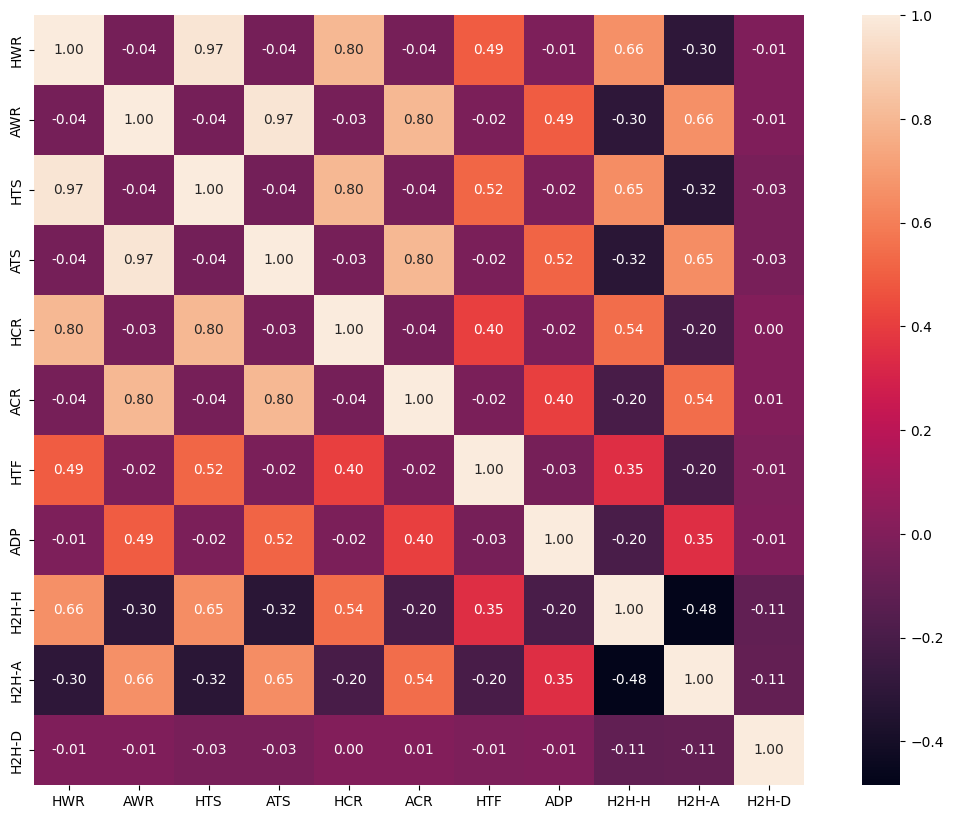

In [16]:
plt.figure(figsize = (15, 10))

correlation = df_input.corr(numeric_only = True)
sns.heatmap(correlation, annot = True, square = True, fmt = '.2f');

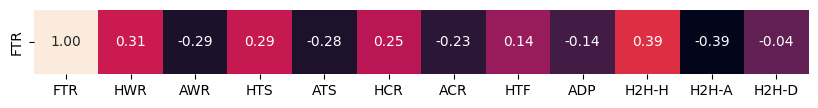

In [17]:
plt.figure(figsize = (10, 2))

df_input['FTR'].replace({'H': 1, 'D': 0, 'A': -1}, inplace = True)

correlation = df_input.corr(numeric_only = True)[['FTR']].T
sns.heatmap(correlation, annot = True, square = True, cbar = False, fmt = '.2f');

In [18]:
X, y = df_input.drop(['HOME', 'AWAY', 'FTR'], axis = 1), df_input['FTR'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [19]:
# Min-Max Scaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [20]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

lr.fit(X_train, y_train)
y_lr = lr.predict(X_test)

accuracy_score(y_test, y_lr)

print(classification_report(y_test, y_lr, digits = 4))

              precision    recall  f1-score   support

          -1     0.5952    0.5952    0.5952       252
           0     0.4762    0.3125    0.3774       160
           1     0.6322    0.7339    0.6793       342

    accuracy                         0.5981       754
   macro avg     0.5679    0.5472    0.5506       754
weighted avg     0.5868    0.5981    0.5871       754



In [21]:
from sklearn.svm import SVC

svm = SVC()

svm.fit(X_train, y_train)
y_svm = svm.predict(X_test)

accuracy_score(y_test, y_svm)

print(classification_report(y_test, y_svm, digits = 4))

              precision    recall  f1-score   support

          -1     0.5896    0.5873    0.5885       252
           0     0.4430    0.2188    0.2929       160
           1     0.6250    0.7749    0.6919       342

    accuracy                         0.5942       754
   macro avg     0.5526    0.5270    0.5244       754
weighted avg     0.5746    0.5942    0.5727       754



In [22]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

gnb.fit(X_train, y_train)
y_gnb = gnb.predict(X_test)

accuracy_score(y_test, y_gnb)

print(classification_report(y_test, y_gnb, digits = 4))

              precision    recall  f1-score   support

          -1     0.5686    0.6746    0.6171       252
           0     0.4175    0.2687    0.3270       160
           1     0.6562    0.6754    0.6657       342

    accuracy                         0.5889       754
   macro avg     0.5474    0.5396    0.5366       754
weighted avg     0.5763    0.5889    0.5776       754



In [23]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

knn.fit(X_train, y_train)
y_knn = knn.predict(X_test)

accuracy_score(y_test, y_knn)

print(classification_report(y_test, y_knn, digits = 4))

              precision    recall  f1-score   support

          -1     0.5189    0.5992    0.5562       252
           0     0.3864    0.3187    0.3493       160
           1     0.6254    0.6053    0.6152       342

    accuracy                         0.5424       754
   macro avg     0.5102    0.5077    0.5069       754
weighted avg     0.5391    0.5424    0.5390       754



In [24]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

rf.fit(X_train, y_train)
y_rf = rf.predict(X_test)

accuracy_score(y_test, y_rf)

print(classification_report(y_test, y_rf, digits = 4))

              precision    recall  f1-score   support

          -1     0.4917    0.4683    0.4797       252
           0     0.3309    0.2875    0.3077       160
           1     0.5867    0.6433    0.6137       342

    accuracy                         0.5093       754
   macro avg     0.4698    0.4663    0.4670       754
weighted avg     0.5006    0.5093    0.5040       754



In [25]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()

dt.fit(X_train, y_train)
y_dt = dt.predict(X_test)

accuracy_score(y_test, y_dt)

print(classification_report(y_test, y_dt, digits = 4))

              precision    recall  f1-score   support

          -1     0.4700    0.5595    0.5109       252
           0     0.3203    0.2562    0.2847       160
           1     0.5982    0.5702    0.5838       342

    accuracy                         0.5000       754
   macro avg     0.4628    0.4620    0.4598       754
weighted avg     0.4964    0.5000    0.4960       754



In [26]:
X = scaler.fit_transform(X)

lr = LogisticRegression()
cv_lr = cross_val_score(lr, X, y).mean()
# print(cv_lr)

svm = SVC()
cv_svm = cross_val_score(svm, X, y).mean()
# print(cv_svm)

gnb = GaussianNB()
cv_gnb = cross_val_score(gnb, X, y).mean()
# print(cv_gnb)

knn = KNeighborsClassifier()
cv_knn = cross_val_score(knn, X, y).mean()
# print(cv_knn)

rf = RandomForestClassifier()
cv_rf = cross_val_score(rf, X, y).mean()
# print(cv_rf)

dt = DecisionTreeClassifier()
cv_dt = cross_val_score(dt, X, y).mean()
# print(cv_dt)

In [27]:
# Grid Search CV (LR)

lr = LogisticRegression()

grid = {'C': [0.1, 1.0], 'solver': ['liblinear', 'newton-cg']}

clf = GridSearchCV(lr, grid)
clf.fit(X_train, y_train)

print(clf.best_params_)
print(clf.best_score_)

gs_lr = clf.predict(X_test)
accuracy_score(y_test, gs_lr)

{'C': 1.0, 'solver': 'liblinear'}
0.582089552238806


0.596816976127321

In [28]:
# Grid Search CV (SVM)

svm = SVC()

grid = {'C': [0.1, 1.0], 'kernel': ['linear', 'poly', 'rbf']}

clf = GridSearchCV(svm, grid)
clf.fit(X_train, y_train)

print(clf.best_params_)
print(clf.best_score_)

gs_svm = clf.predict(X_test)
accuracy_score(y_test, gs_svm)

{'C': 1.0, 'kernel': 'rbf'}
0.5837479270315091


0.5941644562334217

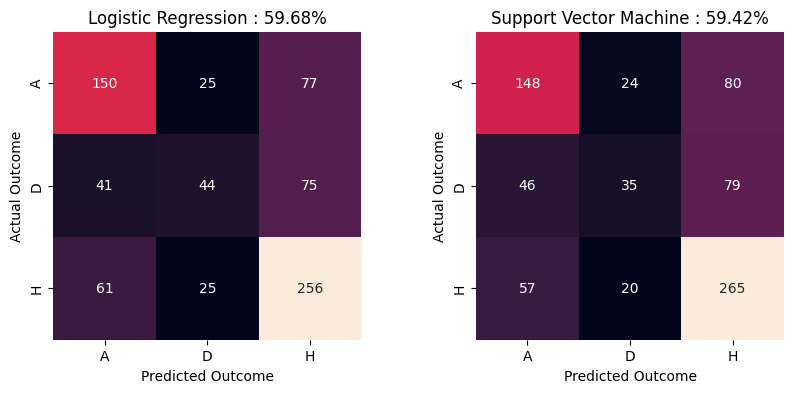

In [29]:
figure, axes = plt.subplots(1, 2, figsize = (10, 4))

cm = confusion_matrix(y_test, gs_lr)
sns.heatmap(cm, annot = True, square = True, cbar = False, fmt = 'd', ax = axes[0])

axes[0].set(xlabel = 'Predicted Outcome', ylabel = 'Actual Outcome')
axes[0].set(xticklabels = ['A', 'D', 'H'], yticklabels = ['A', 'D', 'H'])

percent = (accuracy_score(y_test, gs_lr) * 100).round(2)
axes[0].set_title(f'Logistic Regression : {percent}%')

cm = confusion_matrix(y_test, gs_svm)
sns.heatmap(cm, annot = True, square = True, cbar = False, fmt = 'd', ax = axes[1])

axes[1].set(xlabel = 'Predicted Outcome', ylabel = 'Actual Outcome')
axes[1].set(xticklabels = ['A', 'D', 'H'], yticklabels = ['A', 'D', 'H'])

percent = (accuracy_score(y_test, gs_svm) * 100).round(2)
axes[1].set_title(f'Support Vector Machine : {percent}%')

plt.show()